In [1]:
'''
__author__ = 'Alex Cheng'
Python集成方法工具包解决回归问题,引入非数值属性
ensemble
对于鲍鱼年龄预测，看到随机森林和梯度提升都没有显著的差异，
无论梯度提升法采用决策树还是随机森林作为基学习期（改变max_features大小）
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score,mean_squared_error
from math import sqrt
import random

In [2]:
target_url2 = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
"abalone/abalone.data")
df = pd.read_csv(target_url2,header=None,prefix="V")
df.columns = ['Sex','Length','Diameter','Heigth','Whole weight',
              'Shucked weight','Viscera weight','Shell weight','Rings']

In [4]:
df.head()

,Sex,Length,Diameter,Heigth,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [18]:
# 原始数组
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
names = df.columns

# 将sex属性装换为数值型
xCoded = []
for row in xList:
    codedSex = [0.0,0.0] # 对应三种性别属性，还有未知
    if row[0] == 'M': codedSex[0] = 1.0
    if row[0] == 'F': codedSex[1] = 1.0
    
    numRow = [float(row[i]) for i in range(1,len(row))] # 其他值转换成float
    rowCoded = list(codedSex) + numRow # 合并性别one-hot编码和其他属性
    xCoded.append(rowCoded) 
    # 不包含标签
    namesCoded = ['Sex1','Sex2'] + list(df.columns[1:-1])
    # 包含标签
    namesCoded = ['Sex1','Sex2'] + list(df.columns[1:])
 
nrows = len(xCoded)
ncols = len(xCoded[0])
namesCoded
#print(xCoded[0])

['Sex1',
 'Sex2',
 'Length',
 'Diameter',
 'Heigth',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight',
 'Rings']

In [8]:
# 要求数据为np.array格式
x = np.array(xCoded)
y = np.array(labels)
abaloneNames = np.array(namesCoded)

# model_selection
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.30,random_state=828)

No handles with labels found to put in legend.


The index of min error:  37
Min MSE with RF treeDepth None maxTree 490 : 5.163437403935524


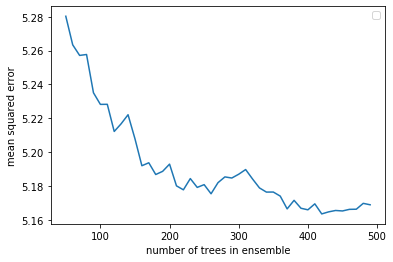

In [42]:
mse = []
nTreeList = range(50,500,10)
for iTree in nTreeList:
    depth = None
    maxFeat = 4
    # 随机森林
    abaloneRF = ensemble.RandomForestRegressor(n_estimators=iTree,
                 max_depth=depth,max_features=maxFeat,oob_score=False,random_state=828)
    
    abaloneRF.fit(xTrain,yTrain)
    
    # 累计mse 在测试集
    pred = abaloneRF.predict(xTest)
    mse.append(mean_squared_error(yTest,pred))


print("The index of min error: ",mse.index(min(mse)))
print('Min MSE with RF treeDepth',depth,'maxTree',max(nTreeList), ":", min(mse))

# 训练集的错误 vs 树的数量
plt.figure()
plt.plot(nTreeList,mse)
plt.legend(loc='upper right')
plt.xlabel("number of trees in ensemble")
plt.ylabel('mean squared error')
plt.show()


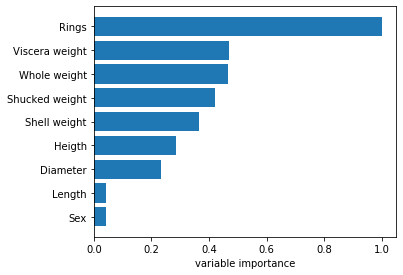

In [41]:
# 特征重要性
featImportance = abaloneRF.feature_importances_
featImportance = featImportance / featImportance.max()
#print(len(featImportance))
idxSorted = np.argsort(featImportance)
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos,featImportance[idxSorted], align='center') # 水平柱状图
plt.yticks(barPos, abaloneNames[idxSorted]) # np.array的数组可以[]取值
plt.xlabel('variable importance')
plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1)
plt.show()


The index of min error:  3769
Min MSE with RF treeDepth 5 maxTree 490 : 5.040036895115388


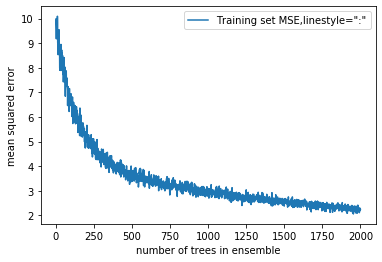

In [48]:
# 梯度提升回归
nEst = 2000
depth =  5
learnRate = 0.005
maxFeat = 3
subsamp = 0.5


abaloneGB = ensemble.GradientBoostingRegressor(n_estimators=nEst,max_depth=depth,
                learning_rate=learnRate,max_features=maxFeat,subsample=subsamp,loss='ls')
    
abaloneGB.fit(xTrain,yTrain)
    
# 梯度提升自带staged迭代属性
#pred = abaloneGB.staged_decision_function(xTest)
mse2 = []
pred = abaloneGB.staged_predict(xTest)
for p in pred:
    mse2.append(mean_squared_error(yTest,p))

print("The index of min error: ",mse.index(min(mse)))
print('Min MSE with RF treeDepth',depth,'maxTree',max(nTreeList), ":", min(mse))

# 训练集的错误 vs 树的数量
plt.figure()
plt.plot(range(1,nEst+1), abaloneGB.train_score_, label='Training set MSE,linestyle=":"')
plt.legend(loc='upper right')
plt.xlabel("number of trees in ensemble")
plt.ylabel('mean squared error')
plt.show()


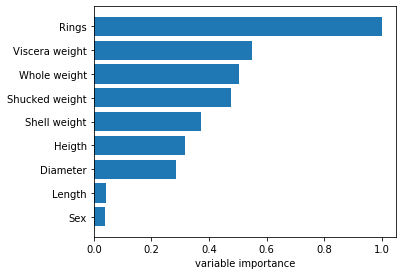

In [47]:
# 特征重要性
featImportance = abaloneGB.feature_importances_
featImportance = featImportance / featImportance.max()
#print(len(featImportance))
idxSorted = np.argsort(featImportance)
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos,featImportance[idxSorted], align='center') # 水平柱状图
plt.yticks(barPos, abaloneNames[idxSorted]) # np.array的数组可以[]取值
plt.xlabel('variable importance')
plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1)
plt.show()